In [1]:
import csv
import pandas as pd
import os
from matplotlib import pyplot as plt
import time
from textwrap import wrap
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout

In [2]:
def plot_crime_stats(df, offense_types = ['ROBBERY', 'ARSON'], years = [ 2001, 2019 ], \
                             report_type = 'Month'):
    # this is a function for creating the plots; there are 3 types of plots
    # (1) plot for yearly data where the year is selected from the widget; X-axis = 2001 through 2019
    #    and Y-axis = count of the offense for each year
    # (2) plot for a 5-year period also chosen from the widget; X-axis 2001-2005, 2006-2010, 2011-2015 and 2016-later)
    #    and Y-axis = count of the offense for each 5-year period
    # (3) plot for Month - means X-axis = January through December
    #    and Y-axis = count of the offense for each month of a given year
    #validate report type - give an error message if not "Year", "5Year" or "Month" type plot
    if report_type != 'Month' and report_type != 'Year' and report_type != '5Years':
        print(' Unsupported report type')
        return
    
    #validate years
    if len(years) < 2 or years[0] > years[1]:
        years = [2001, 2019]
    elif years[0] < 2001:
        years[0] = 2001
    elif years[1] > 2019:
        years[1] = 2019 
        
    df['Year'] = pd.DatetimeIndex(df['Date']).year
        
    cols = list(df.columns.values)
    df1 = pd.DataFrame(columns=cols)
    
    # for 5 years report, the years must be from 2001 to 2019
    if report_type == '5Years':
        years[0] = 2001
        years[1] = 2019
        
    for i in offense_types:
        df2 = df.loc[ (df['Offense Type'] == i)  &  \
                        (df['Year'] >= years[0]) & (df['Year'] <= years[1]), :]
        df1 = df1.append(df2, ignore_index = True)
    
    if report_type == '5Years':
        df1.loc[df1.Year <= 2005, 'Year'] = 1
        df1.loc[ (df1.Year <= 2010) & (df1.Year > 2005 ), 'Year'] = 2
        df1.loc[ (df1.Year <= 2015) & (df1.Year > 2010 ), 'Year'] = 3
        df1.loc[ df1.Year >2015, 'Year'] = 4
        df1.rename(columns={'Year':'5Years'},  inplace=True)
   
    # process monthly report
    if report_type == 'Month':
        df1[report_type] = pd.DatetimeIndex(df1['Date']).month
            
    cols = [ 'Offense Type', report_type, 'Crime Count']
    df1 = df1.loc[:, cols]
    df1 = df1.groupby(['Offense Type',report_type ])['Crime Count'].sum().reset_index()
  
    dict_frame = {}
    cime_types = df1['Offense Type'].unique()
    rtype_list = df1[report_type].unique()
    for i in offense_types:
        count = [ 0 for i in rtype_list ]
        for j in rtype_list:
            dff = df1.loc[(df1['Offense Type'] == i) & (df1[report_type] == j), : ]
            if len(dff) != 0:
                count[int(j)-rtype_list[0]] = dff.reset_index(drop=True).at[0, 'Crime Count']
        dict_frame[i] = count
    
    x_axis = []
    if report_type == 'Month':   
        x_axis = ['January','February','March','April','May','June', \
                           'July','August','September','October','November','December']
    elif  report_type == '5Years':
        x_axis =  [ '2001 to 2005','2006 to 2010','2011 to 2015', '2016 and later' ]
    else:
        x_axis = [ i for i in range(years[0], years[1] + 1) ]
        
    df1 = pd.DataFrame(dict_frame,  index=x_axis)
    index_values = df1.index.values
    
    
    # plot the data frame
    if report_type == 'Year':
        plt.figure(figsize=(16, 8))
        #plt.legend(offense_types, loc='upper center')
        multi_plot = df1.plot(y=list(df1.columns.values),
                     figsize=(10,5),title="One Year Trends of Selected Crimes in Chicago", grid=True)
        multi_plot.set_xlabel("Time Interval")
        multi_plot.set_ylabel("Number of Incidents")
        #multi_plot.legend(offense_types, loc='upper right')
        #plt.show()
    elif  report_type == '5Years':
        plt.figure(figsize=(16, 8))
        #plt.legend(offense_types, loc='upper right')
        multi_plot = df1.plot(y=list(df1.columns.values),
                     figsize=(10,5),title="5-Year Trends of Selected Crimes in Chicago", grid=True)
        multi_plot.set_xlabel("Time Interval")
        multi_plot.set_ylabel("Number of Incidents")
        multi_plot.text(0.95, 0.6, "Note:\n5-year totals for each 5-year period presented here.", \
                        fontsize=14, transform=plt.gcf().transFigure)
        #multi_plot.legend(offense_types, loc='upper right')
        plt.show()
    elif report_type == 'Month':
        ci = 0
        gap = 1/len(df1.columns.values) - 0.01
        colors = ['r','b', 'coral', 'g', 'y', 'k']
        plt.figure(figsize=(16, 8))
        plt.title("Chicago Crime Statistics - from "+ str(years[0]) + " to " +  str(years[1]))
        #plt.legend(offense_types, loc='upper right')
        for crime in list(df1.columns.values):
            plt.bar([ i + ci* gap for i in range(len(index_values))], df1[crime], alpha=1, \
                                  width=gap, color=colors[ci], align="center")
            ci = (ci + 1 ) % len(colors)
        plt.xticks( [ i for i in range(len(index_values)) ], index_values, fontsize=14, rotation="vertical" )
        plt.ylabel("Number of Incidents")
        plt.legend(offense_types, loc='upper right')
        #plt.show()
    #plt.show()

In [3]:
if __name__ == '__main__':
    # reads the input file and cleans the data by removing non-criminal offenses
    print('Started reading at ..... ', time.asctime(time.localtime(time.time())) )
    file = os.path.join('Resources','Crimes_2001_to_present.csv')
    df = pd.read_csv(file)
    print('Completed reading at ..... ', time.asctime(time.localtime(time.time())) )
    print('Beginning processing at ..... ', time.asctime(time.localtime(time.time())) )
    start_time = time.time() 
    cols = ['ID', 'Case Number', 'Date', 'Primary Type', 'Ward']
    df = df.loc[:, cols]
    df = df[df['Primary Type'] != 'NON - CRIMINAL' ]
    df = df[df['Primary Type'] != 'NON-CRIMINAL' ] 
    df = df[df['Primary Type'] != 'NON-CRIMINAL (SUBJECT SPECIFIED)' ]
    # print('Total=',df.ID.count())     #6900557
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    # get the crime count based on TYPE and Date stamp
    groupedby = df.groupby(['Primary Type', 'Date'])
    crime_counts = groupedby["ID"].count()
    elapsed_time = time.time() - start_time
    print("Elapsed time= ", elapsed_time)   # 15 minutes
    print('Completed loading reading ..... ', time.asctime(time.localtime(time.time())) )
    crime_count_df = pd.DataFrame(crime_counts).reset_index()
    crime_count_df.columns = [ 'Offense Type', 'Date', 'Crime Count' ]

Started reading at .....  Fri Jul 12 20:37:46 2019
Completed reading at .....  Fri Jul 12 20:40:06 2019
Beginning processing at .....  Fri Jul 12 20:40:07 2019
Elapsed time=  905.6012766361237
Completed loading reading .....  Fri Jul 12 20:55:12 2019


<Figure size 1152x576 with 0 Axes>

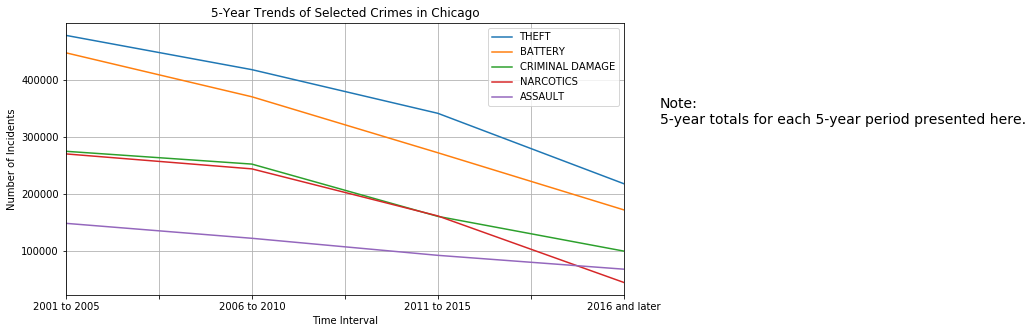

In [4]:
if __name__ == '__main__':
    # calling the function "plot_crime_stats" to do a "5-year" plot
    plot_crime_stats(crime_count_df, offense_types = ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT'], \
                                         report_type= '5Years')

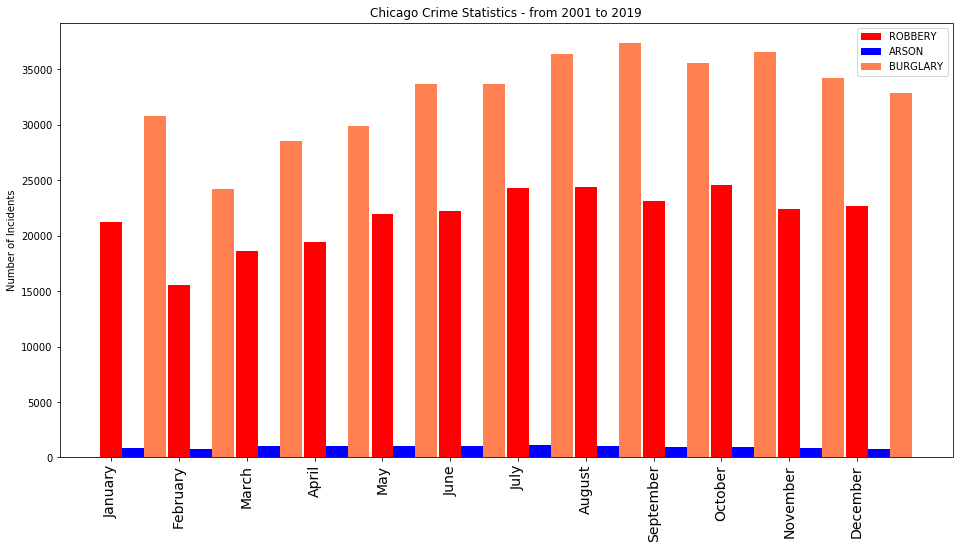

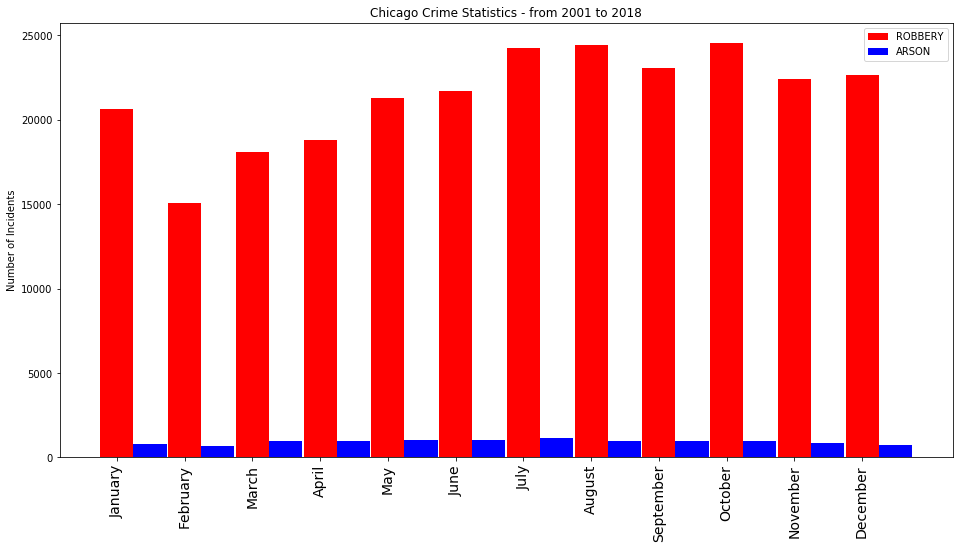

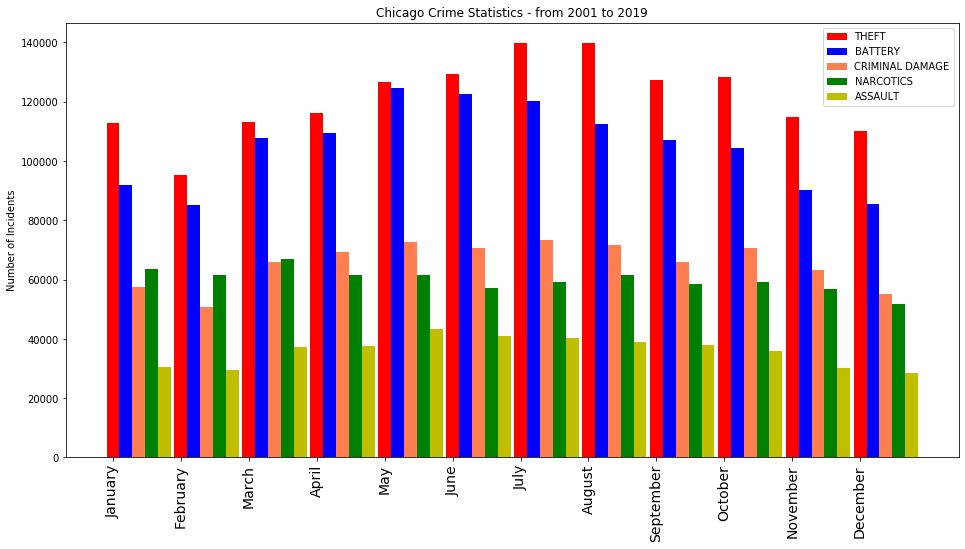

In [5]:
if __name__ == '__main__':
    # calling the function "plot_crime_stats" to do a plot by "Month" by selecting the year
    plot_crime_stats(crime_count_df, offense_types = ['ROBBERY', 'ARSON','BURGLARY'], years = [ 2001, 2019 ], report_type= 'Month')
    plot_crime_stats(crime_count_df, offense_types = ['ROBBERY', 'ARSON'], years = [ 2001, 2018 ], report_type= 'Month')
    plot_crime_stats(crime_count_df, \
                      offense_types = [ 'THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT' ], years = [ 2001, 2019 ], \
                      report_type= 'Month')

<Figure size 1152x576 with 0 Axes>

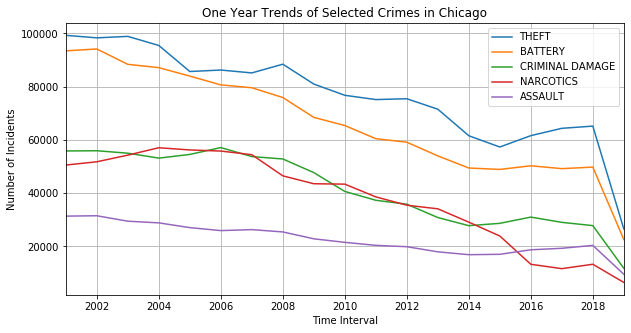

<Figure size 1152x576 with 0 Axes>

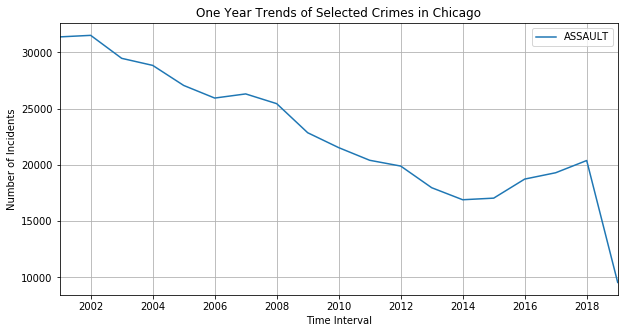

<Figure size 1152x576 with 0 Axes>

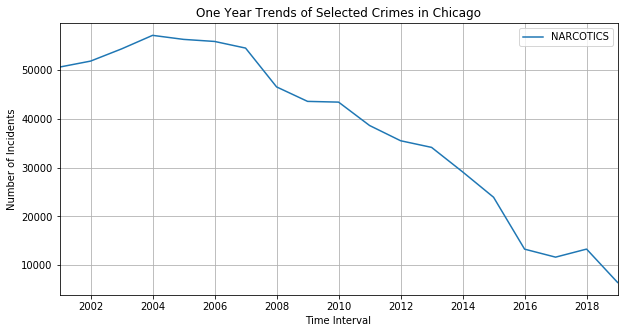

In [6]:
if __name__ == '__main__':
    # calling the function "plot_crime_stats" to do a plot by "Year" for the entire range of years
    plot_crime_stats(crime_count_df, offense_types = ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT'], \
                                          years = [ 2001, 2019 ], report_type= 'Year')
    plot_crime_stats(crime_count_df, offense_types = ['ASSAULT'], years = [ 2001, 2019 ], report_type = 'Year')
    plot_crime_stats(crime_count_df, offense_types = ['NARCOTICS'], years = [ 2001, 2019 ], report_type = 'Year')